# composite models: two 'columns', each containing two neuron layers

In [1]:
import numpy as np
from spikeflow import BPNNModel, CompositeLayer, IzhikevichNeuronLayer
from spikeflow import Synapse, ComplexSynapseLayer
from spikeflow import weights_connecting_from_to, weights_from_synapses, delays_for_weights
from spikeflow import identical_sampler, normal_sampler, normal_ints_sampler
from spikeflow.drawing_utils.trace_renderers import *

/Applications/Anaconda/anaconda/envs/mlbook/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Create a model with two 'groups' ('columns'?) of neuron layers - each group has one recurrently-connected neuron layer, connecting to one 'decoder' layer. First group connects to second group.

In [2]:
model_input_shape = (3,)

def create_composite_layer(name):
    
    neuron_layer_0 = IzhikevichNeuronLayer.layer_from_tuples('nl0', [
        IzhikevichNeuronLayer.C(a=0.030, b=0.2, c=-65.0, d=6.0, t=30.0, v0=0.0),
        IzhikevichNeuronLayer.C(a=0.035, b=0.2, c=-65.0, d=6.0, t=30.0, v0=0.0),
        IzhikevichNeuronLayer.C(a=0.020, b=0.2, c=-65.0, d=6.0, t=30.0, v0=0.0),
    ])

    neuron_layer_1 = IzhikevichNeuronLayer.layer_from_tuples('nl1', [
        IzhikevichNeuronLayer.C(a=0.010, b=0.2, c=-65.0, d=6.0, t=30.0, v0=0.0),
        IzhikevichNeuronLayer.C(a=0.015, b=0.2, c=-65.0, d=6.0, t=30.0, v0=0.0)
    ])

    recurrent_weights = weights_connecting_from_to(
        neuron_layer_0, 
        neuron_layer_0, 
        1.0, 
        normal_sampler(2.0, 1.0))

    recurrent_connection = ComplexSynapseLayer(
        name = 'rec_syn',
        from_layer = neuron_layer_0, 
        to_layer = neuron_layer_0, 
        decay = 0.95, 
        weights = recurrent_weights,
        delay = delays_for_weights(recurrent_weights, normal_ints_sampler(10, 5))
    )
            
    forward_connection = ComplexSynapseLayer(
        name = 'forward_syn',
        from_layer = neuron_layer_0, 
        to_layer = neuron_layer_1, 
        decay = 0.95, 
        delay = np.array([[5, 10], [8, 4], [3, 7]]),
        weights = weights_from_synapses(neuron_layer_0, neuron_layer_1, [
            Synapse(0, 0, 5.0),
            Synapse(1, 0, 10.0),
            Synapse(2, 0, 15.0),
            Synapse(0, 1, 8.0),
            Synapse(1, 1, 10.0),
            Synapse(2, 1, 12.0)
        ])
    )

    return CompositeLayer(name, 
                          [neuron_layer_0, neuron_layer_1], 
                          [recurrent_connection, forward_connection])

cl0 = create_composite_layer('cl0')
cl1 = create_composite_layer('cl1')

cl0_to_cl1 = ComplexSynapseLayer(
    name = 'cl0_to_cl1',
    from_layer = cl0, 
    to_layer = cl1, 
    decay = 0.95, 
    delay = 50,
    weights = weights_from_synapses(cl0, cl1, [
        Synapse(0, 0, 5.0),
        Synapse(0, 1, 10.0),
        Synapse(0, 2, 15.0),
        Synapse(1, 0, 8.0),
        Synapse(1, 1, 10.0),
        Synapse(1, 2, 12.0)
    ]))

model = BPNNModel.compiled_model(model_input_shape, [cl0, cl1], [cl0_to_cl1])

# Run the model for 2000 timesteps

In [3]:
traces = []
def end_time_step_callback(i, graph, sess, results):
    traces.append(results)
    
def data_generator():
    for i in range(0, 2000):
        yield np.ones(3,)*(7 if (i > 1200 and i < 1800) else 0)
    
model.run_time(data_generator(), end_time_step_callback)

# Extract the data we want and display

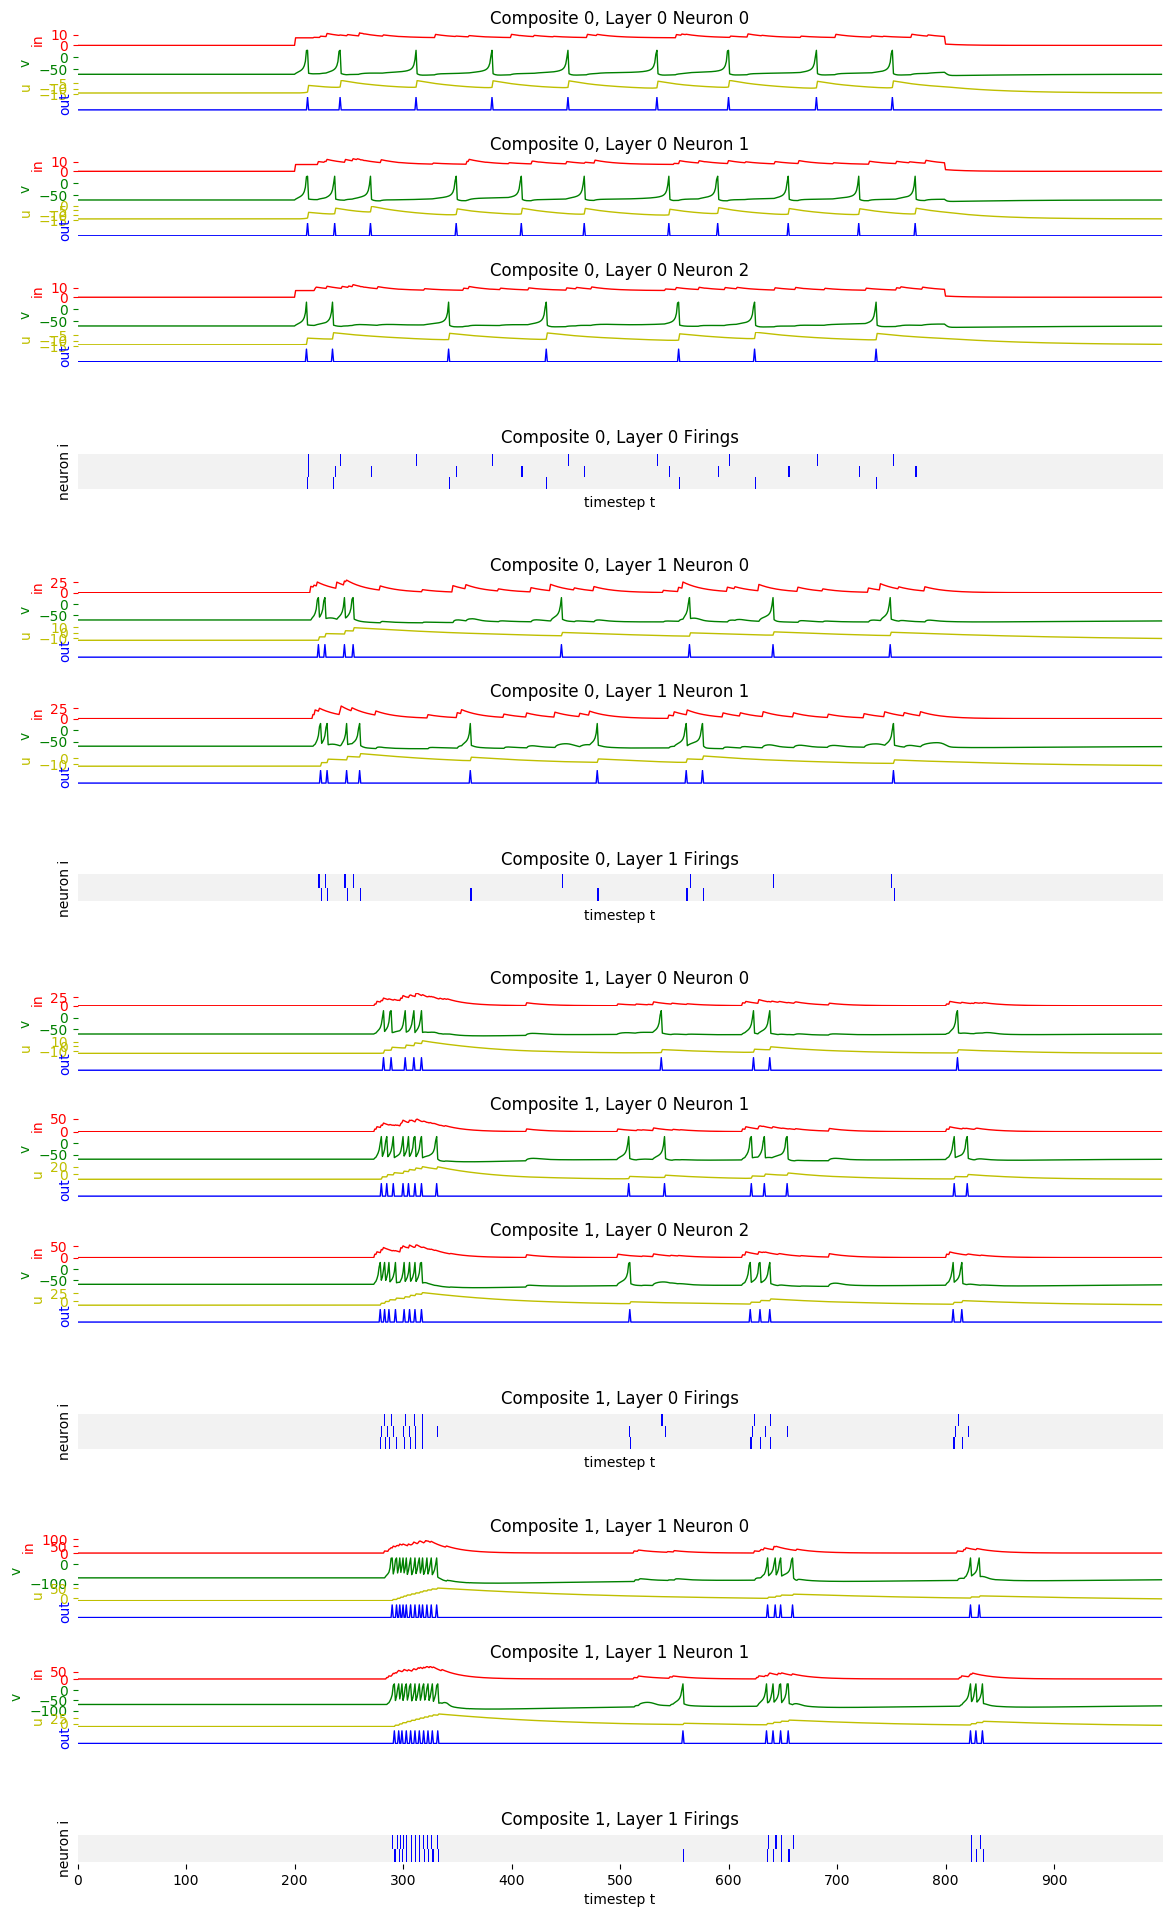

In [4]:
neuron_layer_0_traces = np.array([r['cl0']['nl0'] for r in traces])
neuron_layer_1_traces = np.array([r['cl0']['nl1'] for r in traces])
neuron_layer_2_traces = np.array([r['cl1']['nl0'] for r in traces])
neuron_layer_3_traces = np.array([r['cl1']['nl1'] for r in traces])

render_figure([IzhikevichNeuronTraceRenderer(neuron_layer_0_traces, 'Composite 0, Layer 0 Neuron'),
               NeuronFiringsRenderer(neuron_layer_0_traces[:,3,:], 30, 'Composite 0, Layer 0 Firings'),
               IzhikevichNeuronTraceRenderer(neuron_layer_1_traces, 'Composite 0, Layer 1 Neuron'), 
               NeuronFiringsRenderer(neuron_layer_1_traces[:,3,:], 30,'Composite 0, Layer 1 Firings'),
               IzhikevichNeuronTraceRenderer(neuron_layer_2_traces, 'Composite 1, Layer 0 Neuron'), 
               NeuronFiringsRenderer(neuron_layer_2_traces[:,3,:], 30,'Composite 1, Layer 0 Firings'),
               IzhikevichNeuronTraceRenderer(neuron_layer_3_traces, 'Composite 1, Layer 1 Neuron'), 
               NeuronFiringsRenderer(neuron_layer_3_traces[:,3,:], 30,'Composite 1, Layer 1 Firings')
              ],
              1000, 2000, 100)